In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import norm

# import sklearn
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

In [3]:
pd.options.display.max_columns = None
%matplotlib inline
sns.set(style="darkgrid")
random_seed = 42

In [4]:
columns = ['Datetime_UTC', 'Demand_m3', 'Data_status']
df = pd.read_csv('data/Water_usage_minute_2010_2020.txt', names=columns, header=None, delimiter='|')
df.head()

,Datetime_UTC,Demand_m3,Data_status
0,2009-12-31T23:00:00.000000Z,5872.591797,0
1,2009-12-31T23:01:00.000000Z,5864.009766,0
2,2009-12-31T23:02:00.000000Z,5855.428223,0
3,2009-12-31T23:03:00.000000Z,5846.846191,0
4,2009-12-31T23:04:00.000000Z,5838.264648,0


In [5]:
df['Datetime_UTC'] = df['Datetime_UTC'].apply(lambda x: datetime.fromisoformat(x.replace("Z", "+00:00")))
df.head()

,Datetime_UTC,Demand_m3,Data_status
0,2009-12-31 23:00:00+00:00,5872.591797,0
1,2009-12-31 23:01:00+00:00,5864.009766,0
2,2009-12-31 23:02:00+00:00,5855.428223,0
3,2009-12-31 23:03:00+00:00,5846.846191,0
4,2009-12-31 23:04:00+00:00,5838.264648,0


In [117]:
data = df.copy()
data['Datetime_UTC'] = pd.to_datetime(data['Datetime_UTC'], unit='ms')
data = data.loc[data.Datetime_UTC.between('2010-01-01', '2020-08-31')]
data.set_index('Datetime_UTC', inplace=True)
data = data.resample('d').sum()/60
#data.index = data.index.date
data = data.fillna(0)
data.head()

,Demand_m3,Data_status
Datetime_UTC,,
2010-01-01 00:00:00+00:00,168366.988411,0.0
2010-01-02 00:00:00+00:00,169425.485075,0.0
2010-01-03 00:00:00+00:00,176486.602049,0.0
2010-01-04 00:00:00+00:00,182879.800460,0.0
2010-01-05 00:00:00+00:00,179537.108252,0.0


In [8]:
def ts_analysis_plots(data, n_lags):  
    
    # AD Fuller test and linear trend of the time series
    trend, coefs = TargetTransformer.get_trend(data)
    a, b = coefs[0], coefs[1]
    adf = adfuller(data)
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    axs = axs.flat

    # combine original timeseries with trendline
    df = pd.concat([data, trend], axis=1)

    # calculate a 12 period rolling mean
    df['rolling_mean'] = data.rolling(12).mean()

    # calculate a 12 period rolling standard deviation
    df['rolling_std'] = data.rolling(12).std()

    # plot dataframe columns against time
    sns.lineplot(data=df, ax=axs[0])
    axs[0].set(xlabel=data.index.name, ylabel=data.name, 
               title=f"Timeseries plot of data (ADF p-value: {round(adf[1], 6)}) \n \
                    (Trend: a={round(coefs[0], 2)}, b={round(coefs[1], 2)})")
        
    # histogram of value distribution
    sns.distplot(data, bins=20, hist=True, kde=True, rug=False, fit=norm, ax=axs[1],
                kde_kws={"label": "KDE"})
    axs[1].set(xlabel=data.name, ylabel="probability", title="Distribution of dataset")
    
    # autocorrelation function
    plot_acf(data, lags=n_lags, ax=axs[2])
    axs[2].set(xlabel="lag", ylabel="ACF value")
    
    # partial autocorrelation function
    plot_pacf(data, lags=n_lags, ax=axs[3])
    axs[3].set(xlabel="lag", ylabel="PACF value")
    
    plt.tight_layout()
    plt.show()

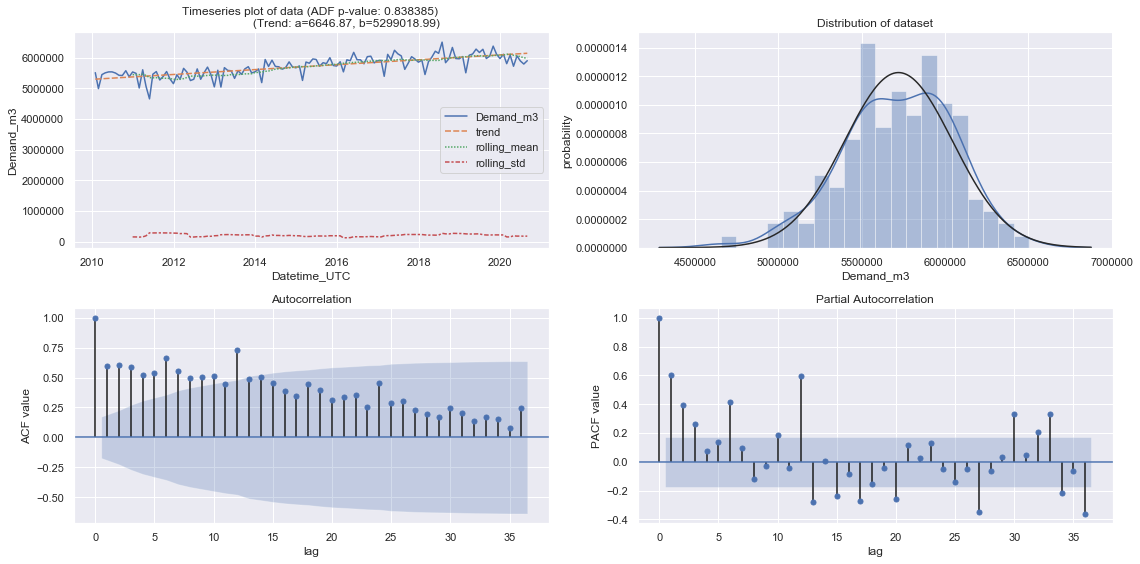

ADF Statistic: -0.731633
p-value: 0.838385
Critical Values:
	1%: -3.489
	5%: -2.887
	10%: -2.580


In [136]:
y = data.resample('M').sum()['Demand_m3']

# Generate plots and calculate ADF values
ts_analysis_plots(y, 36)

# check if dataframe is stationary
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

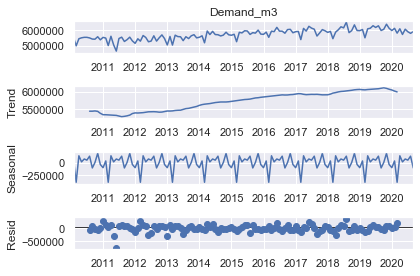

In [141]:
result = seasonal_decompose(y, model='additive', freq=12)
result.plot()

plt.show()

In [132]:
data['year'] = data.index.year
data['week_no'] = pd.Series(data.index.date).apply(lambda x: x.isocalendar()[1]).tolist()
data['day_of_yr'] = pd.Series(data.index.date).apply(lambda x: x.timetuple().tm_yday).tolist()
data.head()

,Demand_m3,Data_status,year,week_no,day_of_yr
Datetime_UTC,,,,,
2010-01-01 00:00:00+00:00,168366.988411,0.0,2010,53,1
2010-01-02 00:00:00+00:00,169425.485075,0.0,2010,53,2
2010-01-03 00:00:00+00:00,176486.602049,0.0,2010,53,3
2010-01-04 00:00:00+00:00,182879.800460,0.0,2010,1,4
2010-01-05 00:00:00+00:00,179537.108252,0.0,2010,1,5


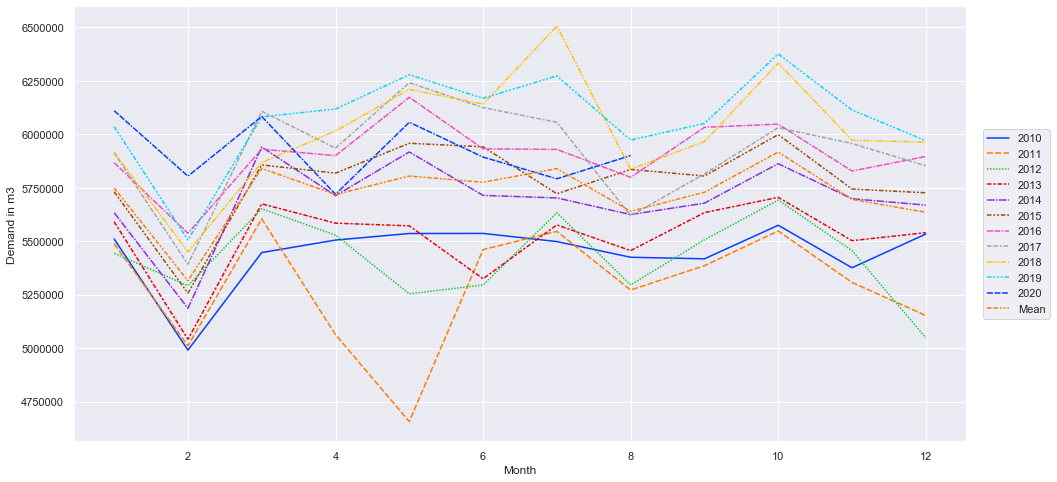

In [129]:
# Plot yearly seasonal trend
df2 = pd.pivot_table(data, index=data.index.month, columns=data.year, values='Demand_m3', aggfunc=np.sum)
df2['Mean'] = df2.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df2, ax=ax, palette='bright')
ax.set(xlabel='Month', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

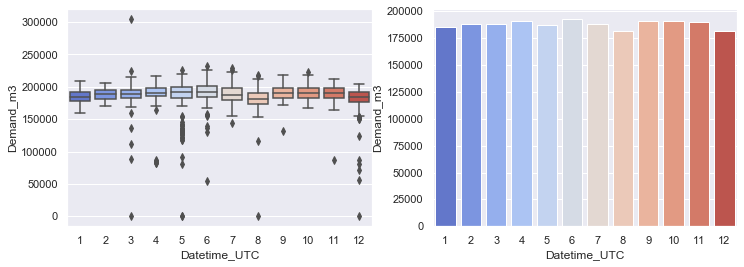

In [153]:
df_monthly = data.copy()
df_monthly.index = df_monthly.index.month
df_averages = df_monthly.groupby(df_monthly.index).mean()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs = axs.flat

sns.boxplot(x=df_monthly.index, y="Demand_m3", palette="coolwarm", data=df_monthly, ax=axs[0])
sns.barplot(x=df_averages.index, y="Demand_m3", palette="coolwarm", data=df_averages, ax=axs[1])

#plt.tight_layout()
plt.show()

In [125]:
df_yearly = data.groupby(data.index.year).sum()['Demand_m3']
df_yearly

Datetime_UTC
2010    6.535232e+07
2011    6.349633e+07
2012    6.509852e+07
2013    6.620267e+07
2014    6.834208e+07
2015    6.939674e+07
2016    7.087534e+07
2017    7.104664e+07
2018    7.217971e+07
2019    7.294843e+07
2020    4.736135e+07
Name: Demand_m3, dtype: float64

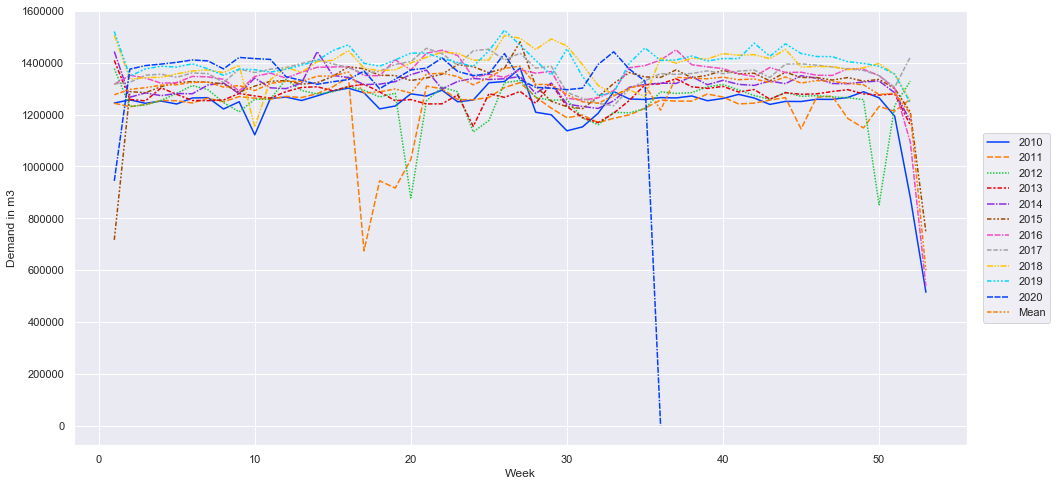

In [134]:
# Plot weekly seasonal trend
df3 = pd.pivot_table(data, index=data.week_no, columns=data.year, values='Demand_m3', aggfunc=np.sum)
df3['Mean'] = df3.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df3, ax=ax, palette='bright')
ax.set(xlabel='Week', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

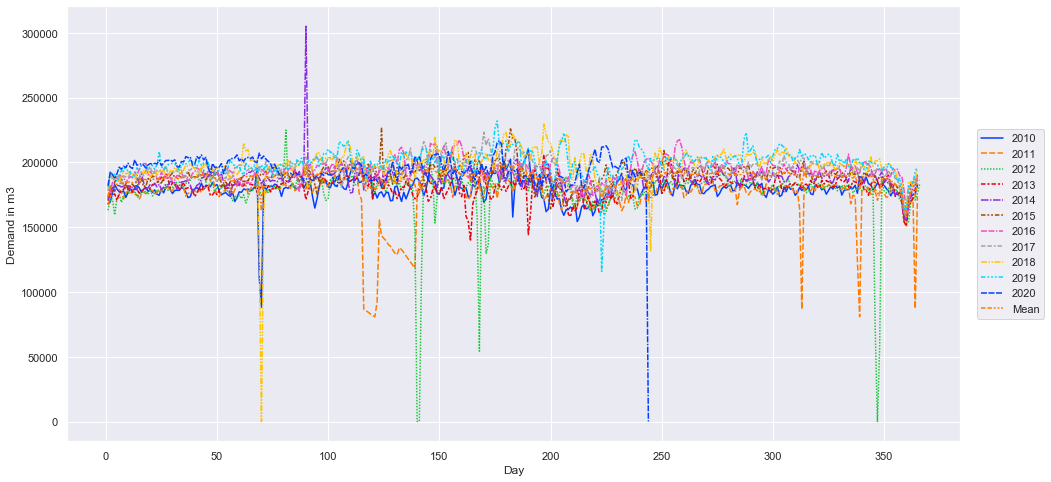

In [133]:
# Plot daily seasonal trend
df4 = pd.pivot_table(data, index=data.day_of_yr, columns=data.year, values='Demand_m3', aggfunc=np.sum)
df4['Mean'] = df4.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df4, ax=ax, palette='bright')
ax.set(xlabel='Day', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()